In [ ]:
from matplotlib import pyplot as plt
from PIL import Image
import torchvision
import numpy as np
import shutil
import random
import torch
import os

%matplotlib inline

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 1.9.0+cu102


In [ ]:
import pandas as pd

In [ ]:
import random
import glob # borrar ficheros con patrones
import shutil #copiar ficheros

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit #para realizar el muestre

In [ ]:
!wget --no-check-certificate \
    https://www.recod.ic.unicamp.br/~aurea.soriano/dataset/covid19.zip \
    -O /tmp/covid19.zip

--2021-08-08 02:58:56--  https://www.recod.ic.unicamp.br/~aurea.soriano/dataset/covid19.zip
Resolving www.recod.ic.unicamp.br (www.recod.ic.unicamp.br)... 143.106.7.142
Connecting to www.recod.ic.unicamp.br (www.recod.ic.unicamp.br)|143.106.7.142|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: http://intranet.recod.ic.unicamp.br/~aurea.soriano/dataset/covid19.zip [following]
--2021-08-08 02:58:57--  http://intranet.recod.ic.unicamp.br/~aurea.soriano/dataset/covid19.zip
Resolving intranet.recod.ic.unicamp.br (intranet.recod.ic.unicamp.br)... 143.106.7.151
Connecting to intranet.recod.ic.unicamp.br (intranet.recod.ic.unicamp.br)|143.106.7.151|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 780769059 (745M) [application/zip]
Saving to: ‘/tmp/covid19.zip’

/tmp/covid19.zip    100%[===================>] 744.60M  3.54MB/s    in 4m 8s   

2021-08-08 03:03:06 (3.01 MB/s) - ‘/tmp/covid19.zip’ saved [780769059/780769059]



In [ ]:
import zipfile

local_zip = '/tmp/covid19.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [ ]:
#ruta donde se descomprimen los fichereros del dataset
os.listdir("/tmp/COVID-19_Radiography_Dataset")

['Viral Pneumonia.metadata.xlsx',
 'Normal.metadata.xlsx',
 'README.md.txt',
 'Normal',
 'COVID.metadata.xlsx',
 'Lung_Opacity',
 'Lung_Opacity.metadata.xlsx',
 'Viral Pneumonia',
 'COVID']

In [ ]:
#removemos los ficheros que no usaremos 
py_files = glob.glob('/tmp/COVID-19_Radiography_Dataset/*.*')
for py_file in py_files:
    try:
        os.remove(py_file)
    except OSError as e:
        print(f"Error:{ e.strerror}")

In [ ]:
root_dir    = '/tmp/COVID-19_Radiography_Dataset' #directorio origen

os.listdir(root_dir)

['Normal', 'Lung_Opacity', 'Viral Pneumonia', 'COVID']

In [ ]:
class_names = ['normal','opacity', 'viral', 'covid']
source_dirs = ['Normal','Lung_Opacity','Viral Pneumonia', 'COVID']

In [ ]:
#se cambia el nombre de las carpetas
for i, d in enumerate(source_dirs):
    os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

In [ ]:
os.listdir(root_dir)

['normal', 'opacity', 'covid', 'viral']

In [ ]:
#dataframe de las imagenes y clases
list_files=[]
for dir in os.listdir(root_dir):
  directory = os.path.join(root_dir,dir) # directorios de las clases
  if os.path.isdir(directory):
    for img in os.listdir(directory):
      list_files.append([os.path.join(dir,img),dir]) #lista de todos los ficheros de cada directorio
df = pd.DataFrame(list_files, columns=['id','clase'])

In [ ]:
df

,id,clase
0,normal/Normal-9311.png,normal
1,normal/Normal-4942.png,normal
2,normal/Normal-3656.png,normal
3,normal/Normal-719.png,normal
4,normal/Normal-8213.png,normal
...,...,...
21160,viral/Viral Pneumonia-1109.png,viral
21161,viral/Viral Pneumonia-73.png,viral
21162,viral/Viral Pneumonia-537.png,viral
21163,viral/Viral Pneumonia-376.png,viral


In [ ]:
df.groupby("clase").agg(frequency=("clase", "count"))

,frequency
clase,
covid,3616
normal,10192
opacity,6012
viral,1345


In [ ]:
df["clase"].unique()

array(['normal', 'opacity', 'covid', 'viral'], dtype=object)

In [ ]:
#Haremos un submuestreo a las clases con mas ejemplos que la clase COVID
def balance_dataset(focus_class, df):
  classes = df["clase"].unique()
  classes_df_list = []
  focus_class_df = df[df["clase"] == focus_class]
  classes_df_list.append(focus_class_df)
  count_focus_class = len(focus_class_df)
  ##Dividimos por clases
  for classe in classes:
    class_df = df[df["clase"] == classe]
    count_class = len(class_df)
    if classe == focus_class:
      continue
    if count_class > count_focus_class+1000:
      class_df = class_df.sample(count_focus_class+1000)
    classes_df_list.append(class_df)
  df_under = pd.concat(classes_df_list, axis=0) 
  return df_under


df = balance_dataset('covid',df)

In [ ]:
df.groupby("clase").agg(frequency=("clase", "count"))

,frequency
clase,
covid,3616
normal,4616
opacity,4616
viral,1345


In [ ]:
root_dir

'/tmp/COVID-19_Radiography_Dataset'

In [ ]:
os.mkdir(root_dir+"/train")
os.mkdir(root_dir+"/test")


os.mkdir(root_dir+"/train/covid")
os.mkdir(root_dir+"/test/covid")

os.mkdir(root_dir+"/train/viral")
os.mkdir(root_dir+"/test/viral")

os.mkdir(root_dir+"/train/normal")
os.mkdir(root_dir+"/test/normal")

os.mkdir(root_dir+"/train/opacity")
os.mkdir(root_dir+"/test/opacity")


In [ ]:
#creamos la función que hará el split de nuestros conjuntos
def split_dataset(df,test_size,random_state = 101):
  sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)#se divide de forma stratificada
  df = df.reset_index()
  for train_index, test_index in sss.split(df['id'], df['clase']):
    X_train, X_test = df['id'][train_index], df['id'][test_index]
    y_train, y_test = df['clase'][train_index], df['clase'][test_index]
  traindf = pd.concat([X_train, y_train], axis=1)
  testdf = pd.concat([X_test, y_test], axis=1)
  return traindf,testdf

In [ ]:
traindf,testdf = split_dataset(df,test_size = 0.10)

In [ ]:
print(traindf['clase'].value_counts())

normal     4154
opacity    4154
covid      3254
viral      1211
Name: clase, dtype: int64


In [ ]:
print(testdf['clase'].value_counts())


normal     462
opacity    462
covid      362
viral      134
Name: clase, dtype: int64


In [ ]:
#visualizamos que todos nuestros conjuntos tienen imagenes diferentes entre ellos 
repetidos=pd.merge(traindf,testdf,how='left',on=['id'])
print(repetidos['clase_y'].unique())


[nan]


In [ ]:
for i in traindf.index:
  shutil.copy(root_dir+"/"+traindf['id'][i],  root_dir+"/train/"+traindf['clase'][i])

In [ ]:
for i in testdf.index:
  shutil.copy(root_dir+"/"+testdf['id'][i],  root_dir+"/test/"+testdf['clase'][i])

In [ ]:
#conteo de ficheros en la clase train
tmp=0
print("Cantidad de datos en Train")
for i in traindf["clase"].unique():
  train=len(os.listdir("/tmp/COVID-19_Radiography_Dataset/train/"+i))
  print(i,str(train))
  tmp=tmp+train
print("Ficheros en Train: "+str(tmp))

Cantidad de datos en Train
normal 4154
covid 3254
opacity 4154
viral 1211
Ficheros en Train: 12773


In [ ]:
#conteo de ficheros en la clase test
tmp=0
print("Cantidad de ficheros en Test")
for i in testdf["clase"].unique():
  test=len(os.listdir("/tmp/COVID-19_Radiography_Dataset/test/"+i))
  print(i,str(test))
  tmp=tmp+test
print("ficheros en Test "+str(tmp))

Cantidad de ficheros en Test
viral 134
opacity 462
normal 462
covid 362
ficheros en Test 1420


# Creating Custom Dataset

In [ ]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name): #Verificar se o aquivo realmente é imagem 'png'
            images = [x for x in os.listdir(image_dirs[class_name]) if x.lower().endswith('png')] 
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.images = {}
        self.class_names = ['normal', 'viral', 'covid','opacity']
        
        for c in self.class_names:
            self.images[c] = get_images(c)
            
        self.image_dirs = image_dirs
        self.transform = transform
          
    def __len__(self):
        return sum([len(self.images[c]) for c in self.class_names])
    
    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index%len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)

# Image Transformations

In [ ]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size = (224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

In [ ]:
test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size = (224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Prepare Loader

In [ ]:
train_dirs = {
    'normal': '/tmp/COVID-19_Radiography_Dataset/train/normal',
    'viral': '/tmp/COVID-19_Radiography_Dataset/train/viral',
    'covid': '/tmp/COVID-19_Radiography_Dataset/train/covid',
    'opacity': '/tmp/COVID-19_Radiography_Dataset/train/opacity'
}

In [ ]:
test_dirs = {
    'normal': '/tmp/COVID-19_Radiography_Dataset/test/normal',
    'viral': '/tmp/COVID-19_Radiography_Dataset/test/viral',
    'covid': '/tmp/COVID-19_Radiography_Dataset/test/covid',
    'opacity': '/tmp/COVID-19_Radiography_Dataset/test/opacity'
}

In [ ]:
train_dataset = ChestXRayDataset(train_dirs, train_transform)

Found 4154 normal examples
Found 1211 viral examples
Found 3254 covid examples
Found 4154 opacity examples


In [ ]:
test_dataset = ChestXRayDataset(test_dirs, test_transform)

Found 462 normal examples
Found 134 viral examples
Found 362 covid examples
Found 462 opacity examples


In [ ]:
batch_size_train = 6
batch_size_test = 6

dl_train = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size_train, shuffle = True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size = batch_size_test, shuffle = True)

print('Number of training batches', len(dl_train))
print('Number of test batches', len(dl_test))

Number of training batches 2129
Number of test batches 237


In [ ]:
class_names = ['normal','viral','covid','opacity']

def show_images(images, labels, preds):
    plt.figure(figsize=(16, 9))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks = [], yticks = [])
        image = image.numpy().transpose((1, 2, 0))
        mean  = np.array([0.485, 0.456, 0.406])
        std   = np.array([0.229, 0.224, 0.225])
        image = image*std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col   = 'green'
        if preds[i] != labels[i]:
            col = 'red'
            
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color = col)
    plt.tight_layout()
    plt.show()

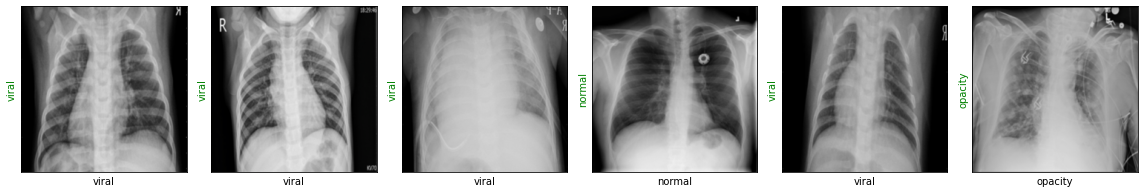

In [ ]:
images, labels = next(iter(dl_train))
show_images(images, labels, labels)

# Creating the Model

In [ ]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print('Dispositivo disponible:', device)

Dispositivo disponible: cuda


In [ ]:
gnet = torchvision.models.squeezenet1_0(pretrained=True)
#gnet.fc = torch.nn.Linear(in_features = 2048, out_features = 4)
gnet.classifier[1] = torch.nn.Conv2d(512, 4, kernel_size=(1,1), stride=(1,1))
print(gnet)

Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-b66bff10.pth



SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
  

In [ ]:
#gnet.fc = torch.nn.Linear(in_features = 1024, out_features = 4)
gnet = gnet.to(device)
loss_fngnet     = torch.nn.CrossEntropyLoss()
optimizer_gnet   = torch.optim.Adam(gnet.parameters(), lr = 3e-5)

In [ ]:
def show_predsgnet():
    gnet.eval()
    images, labels = next(iter(dl_test))
    images = images.to(device)
    labels = labels.to(device)
    outputs  = gnet(images)
    _, preds = torch.max(outputs, 1)
    show_images(images.cpu(), labels.cpu(), preds.cpu())

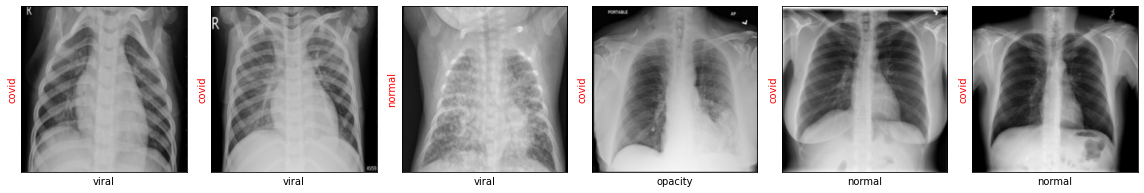

In [ ]:
show_predsgnet()

In [ ]:

train_losses, test_losses = [], []
def train2(epochs):
    print('Starting training..')
    
    rs = '------------------------------------------------------------------'
    print('Epoch    Train-Loss   Train-Acc   Val-Loss    Val-Acc   Best')
    print(rs)
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e + 1}/{epochs}')
        print('='*20)

        train_loss = 0.
        val_loss = 0.

        gnet.train() # set model to training phase

        for train_step, (images, labels) in enumerate(dl_train):
            images = images.to(device)
            labels = labels.to(device)
            optimizer_gnet.zero_grad()
            outputs = gnet(images)
            loss = loss_fngnet(outputs, labels)
            loss.backward()
            optimizer_gnet.step()
            train_loss += loss.item()
            if train_step % 20 == 0:
                print('Evaluating at step', train_step)

                accuracy = 0

                gnet.eval() # set model to eval phase

                for val_step, (images, labels) in enumerate(dl_test):
                    images = images.to(device)
                    labels = labels.to(device)
                    outputs = gnet(images)
                    loss = loss_fngnet(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1)
                    
                    accuracy += torch.sum(preds == labels.data)

                val_loss /= (val_step + 1)
                train_loss /= (train_step + 1)
                accuracy = accuracy/len(test_dataset)
                print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')
                
                train_losses.append(train_loss)
                test_losses.append(val_loss)

                #show_predsgnet()

                gnet.train()

                if accuracy >= 0.954:
                    print('Performance condition satisfied, stopping..')
                    return

        train_loss /= (train_step + 1)

        print(f'Training Loss: {train_loss:.4f}')
    print('Training complete..')

In [ ]:
%%time

train2(epochs=1)

Starting training..
Epoch    Train-Loss   Train-Acc   Val-Loss    Val-Acc   Best
------------------------------------------------------------------
Starting epoch 1/1
Evaluating at step 0
Validation Loss: 2.0004, Accuracy: 0.2261
Evaluating at step 20
Validation Loss: 1.3218, Accuracy: 0.3838
Evaluating at step 40
Validation Loss: 1.1980, Accuracy: 0.4500
Evaluating at step 60
Validation Loss: 1.0426, Accuracy: 0.6373
Evaluating at step 80
Validation Loss: 0.9609, Accuracy: 0.6528
Evaluating at step 100
Validation Loss: 0.9157, Accuracy: 0.6838
Evaluating at step 120
Validation Loss: 0.8374, Accuracy: 0.6718
Evaluating at step 140
Validation Loss: 0.9449, Accuracy: 0.5817
Evaluating at step 160
Validation Loss: 0.7438, Accuracy: 0.7211
Evaluating at step 180
Validation Loss: 0.7452, Accuracy: 0.7366
Evaluating at step 200
Validation Loss: 0.7480, Accuracy: 0.7106
Evaluating at step 220
Validation Loss: 0.7536, Accuracy: 0.7275
Evaluating at step 240
Validation Loss: 0.6233, Accuracy: 0

In [ ]:
import pickle
#pickle.dump(train_losses, open('./train_losses_ResNet50.p', 'wb'))
#pickle.dump(test_losses, open('./test_losses_ResNet50.p', 'wb'))

In [ ]:
#train_loss_sq = pickle.load(open('./train_losses_sqN.p', 'rb'))
#test_loss_sq = pickle.load(open('./test_losses_sqN.p', 'rb'))

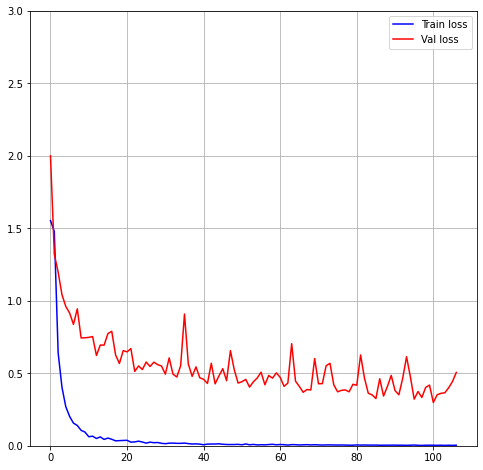

In [ ]:
fig1, axs = plt.subplots(figsize=(8,8))

axs.plot(train_losses, 'b-', label='Train loss')
axs.plot(test_losses, 'r-', label='Val loss')


axs.set_ylim([0, 3])

plt.grid()
plt.legend()
plt.show()

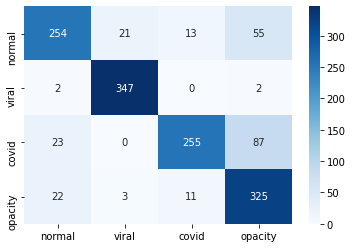

In [ ]:
from sklearn.metrics import confusion_matrix

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long)
lbllist=torch.zeros(0,dtype=torch.long)

gnet.eval()
for val_step, (images, labels) in enumerate(dl_test):
  images = images.to(device)
  labels = labels.to(device)
  outputs = gnet(images)

  _, preds = torch.max(outputs, 1)
  
  # Append batch prediction results
  predlist=torch.cat([predlist,preds.view(-1).cpu()])
  lbllist=torch.cat([lbllist,labels.view(-1).cpu()])

conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
#print(conf_mat)
import seaborn as sns
import pandas as pd
df_cm = pd.DataFrame(conf_mat, index = class_names,
                  columns = class_names)
sns.heatmap(df_cm, annot=True,cmap='Blues',fmt=".0f")

In [ ]:
torch.save(gnet.state_dict(), '/tmp/COVID-19_Radiography_Dataset/my_gnet.pth')

In [ ]:
#Cargamos el modelo guardado
modelgnet_ = torchvision.models.googlenet(pretrained=True)
modelgnet_.fc = torch.nn.Linear(in_features = 1024, out_features = 4)
modelgnet_.load_state_dict(torch.load('/tmp/COVID-19_Radiography_Dataset/my_gnet.pth'))

<All keys matched successfully>

In [ ]:
import torchvision.transforms as T
def transformar_imagen(name):
  '''
  Pre procesamiento de la imagen
  '''
  image = Image.open(name).convert('RGB')

  
  transf = T.Compose([T.Resize(size = (224, 224)),
                      #T.CenterCrop(224),
                      T.ToTensor(), # entre 0 y 1
                      T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])]) # medias y desviacion estandar (Welford's method)
  #image = Image.open(name)
  # Tamaño (3,224,224) => (1, 3, 224, 224)
  return transf(image).unsqueeze(0) # tensor singleton

In [ ]:
def prediccion2(network, name):
  '''
  Predicción con grado de confidencia
  '''
  tensor = transformar_imagen(name)
  network.eval()
  output = network(tensor)
  #output = F.softmax(pred, dim=-1)
  _, pred = torch.max(output,1)
  #index = str(val.item())
  show_images(tensor, pred, pred)
  return pred
  